In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.collocations import *
from nltk import FreqDist
from nltk.probability import FreqDist
from os import path
from PIL import Image
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud, STOPWORDS

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import random
import plotly.io as pio

#display plotly figures
pio.renderers.default = "plotly_mimetype+notebook_connected"

## Load Data

In [2]:
noise_data = pd.read_csv('noise_data.csv')
noise_data.head()

,Unnamed: 0,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Descriptor,Complaint_Type,Resolution_Description,Resolution_Action_UpdatedDate,zipcode,Borough,Latitude,Longitude,Location
0,0,52494258,2021-11-12 23:32:03,11/13/2021 12:01:47 AM,NYPD,New York City Police Department,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complai...,11/13/2021 12:01:53 AM,10009.0,MANHATTAN,40.728098,-73.980986,"(40.72809840521916, -73.98098598390919)"
1,1,52494267,2021-11-12 22:51:56,11/13/2021 02:07:21 AM,NYPD,New York City Police Department,Loud Music/Party,Noise - Residential,The Police Department responded to the complai...,11/13/2021 02:07:28 AM,11385.0,QUEENS,40.703420,-73.910624,"(40.70342006960225, -73.91062391218271)"
2,2,52494269,2021-11-12 21:52:21,11/12/2021 10:46:15 PM,NYPD,New York City Police Department,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complai...,11/12/2021 10:46:20 PM,10012.0,MANHATTAN,40.727491,-74.002594,"(40.727490610002285, -74.00259410868611)"
3,3,52762434,2021-12-10 23:07:33,12/10/2021 11:16:17 PM,NYPD,New York City Police Department,Banging/Pounding,Noise - Residential,The Police Department reviewed your complaint ...,12/10/2021 11:16:21 PM,10456.0,BRONX,40.838195,-73.911184,"(40.83819547525466, -73.91118371113687)"
4,6,47668843,2020-09-24 00:53:51,09/24/2020 02:13:27 AM,NYPD,New York City Police Department,Loud Music/Party,Noise - Residential,The Police Department responded to the complai...,09/24/2020 02:13:29 AM,10456.0,BRONX,40.834562,-73.915424,"(40.83456191927017, -73.91542387418657)"


In [3]:
noise_data['Created_Date'] = pd.to_datetime(noise_data['Created_Date'],format='%Y-%m-%d %H:%M:%S')

In [4]:
noise_data['Created_Date_year'] = noise_data['Created_Date'].dt.year

In [5]:
noise_data.sort_values('Created_Date_year')

,Unnamed: 0,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Descriptor,Complaint_Type,Resolution_Description,Resolution_Action_UpdatedDate,zipcode,Borough,Latitude,Longitude,Location,Created_Date_year
201545,3387396,42681948,2019-05-15 06:12:54,05/15/2019 07:58:46 AM,NYPD,New York City Police Department,Banging/Pounding,Noise - Commercial,The Police Department responded to the complai...,05/15/2019 07:58:46 AM,10128.0,MANHATTAN,40.783241,-73.946825,"(40.78324061970877, -73.94682499027611)",2019
199836,3384120,42652867,2019-05-12 04:23:30,05/12/2019 06:21:37 AM,NYPD,New York City Police Department,Loud Music/Party,Noise - Residential,The Police Department reviewed your complaint ...,05/12/2019 06:21:37 AM,10466.0,BRONX,40.890689,-73.862240,"(40.890689202183296, -73.86223975250938)",2019
199835,3384115,42652861,2019-05-13 01:17:19,05/13/2019 01:37:42 AM,NYPD,New York City Police Department,Loud Music/Party,Noise - Residential,The Police Department responded to the complai...,05/13/2019 01:37:42 AM,10026.0,MANHATTAN,40.803802,-73.947881,"(40.80380187637796, -73.94788135134962)",2019
199834,3384112,42652858,2019-05-12 04:58:22,05/12/2019 06:09:16 AM,NYPD,New York City Police Department,Loud Music/Party,Noise - Residential,Your request can not be processed at this time...,05/12/2019 06:09:16 AM,10466.0,BRONX,40.890689,-73.862240,"(40.890689202183296, -73.86223975250938)",2019
199833,3384111,42652857,2019-05-12 04:33:04,05/12/2019 06:30:52 AM,NYPD,New York City Police Department,Loud Music/Party,Noise - Residential,The Police Department responded to the complai...,05/12/2019 06:30:52 AM,10039.0,MANHATTAN,40.822610,-73.939278,"(40.822609988830635, -73.93927828711236)",2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687433,4468138,50771228,2021-06-04 20:03:45,06/04/2021 08:25:30 PM,NYPD,New York City Police Department,Loud Music/Party,Noise - Street/Sidewalk,The Police Department responded to the complai...,06/04/2021 08:25:34 PM,11233.0,BROOKLYN,40.677170,-73.904610,"(40.677169739110646, -73.90460953364564)",2021
687432,4468131,50771221,2021-06-04 21:42:02,06/04/2021 09:51:06 PM,NYPD,New York City Police Department,Loud Music/Party,Noise - Residential,The Police Department responded to the complai...,06/04/2021 09:51:09 PM,10457.0,BRONX,40.844029,-73.893499,"(40.8440294787858, -73.89349856346438)",2021
687430,4468127,50771198,2021-06-04 22:39:50,06/04/2021 10:50:03 PM,NYPD,New York City Police Department,Car/Truck Music,Noise - Vehicle,The Police Department responded to the complai...,06/04/2021 10:50:07 PM,10030.0,MANHATTAN,40.815771,-73.940762,"(40.81577092076295, -73.94076213231321)",2021
687428,4468125,50771196,2021-06-05 00:39:29,06/05/2021 01:16:56 AM,NYPD,New York City Police Department,Loud Music/Party,Noise - Residential,The Police Department responded to the complai...,06/05/2021 01:16:58 AM,10003.0,MANHATTAN,40.729348,-73.985817,"(40.72934796552927, -73.9858167934437)",2021


# 3年每月的变化

In [6]:
noise_data['year-month'] = noise_data['Created_Date'].dt.year.astype(str) + "-" + noise_data['Created_Date'].dt.month.astype(str)

In [7]:
noise_data_month= noise_data.groupby(noise_data['year-month']).count()

In [8]:
noise_data_month = noise_data_month.reset_index()

In [9]:
noise_data_month.head()

,year-month,Unnamed: 0,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Descriptor,Complaint_Type,Resolution_Description,Resolution_Action_UpdatedDate,zipcode,Borough,Latitude,Longitude,Location,Created_Date_year
0,2019-1,14397,14397,14397,14397,14397,14397,14397,14397,14397,14397,14397,14397,14397,14397,14397,14397
1,2019-10,16474,16474,16474,16474,16474,16474,16474,16474,16474,16474,16474,16474,16474,16474,16474,16474
2,2019-11,12882,12882,12882,12882,12882,12882,12882,12882,12882,12882,12882,12882,12882,12882,12882,12882
3,2019-12,12364,12364,12364,12364,12364,12364,12364,12364,12364,12364,12364,12364,12364,12364,12364,12364
4,2019-2,13925,13925,13925,13925,13925,13925,13925,13925,13925,13925,13925,13925,13925,13925,13925,13925


In [10]:
noise_data_month['year-month'] = pd.to_datetime(noise_data_month['year-month'],format='%Y-%m')

In [11]:
noise_data_month = noise_data_month.sort_values('year-month')

In [12]:
noise_data_month=noise_data_month[['year-month','Unique_Key']]
noise_data_month.head()

,year-month,Unique_Key
0,2019-01-01,14397
4,2019-02-01,13925
5,2019-03-01,16937
6,2019-04-01,19450
7,2019-05-01,25607


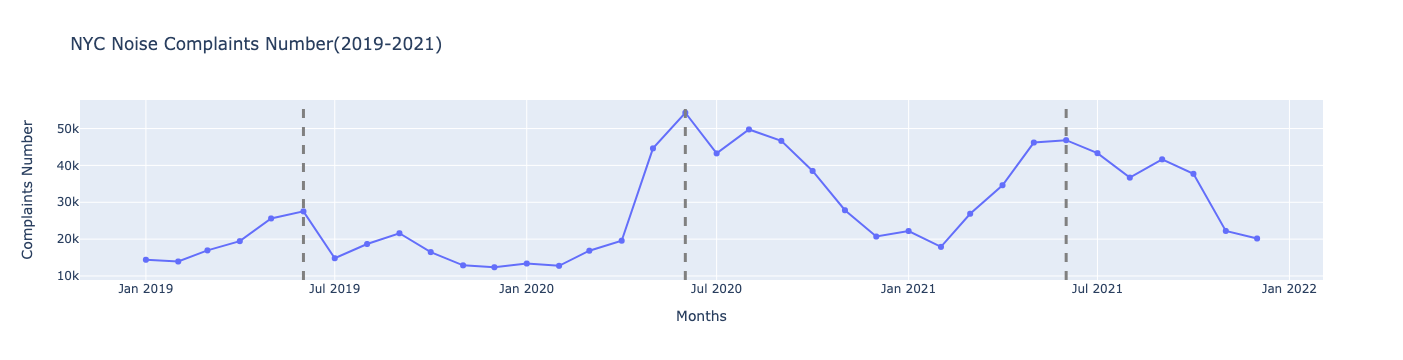

In [42]:
#plot it in an interactive graph
fig = px.line(noise_data_month, x='year-month', y='Unique_Key', markers=True,
labels={"year-month":"Months","Unique_Key":"Complaints Number"},
title="NYC Noise Complaints Number(2019-2021)")
fig.add_vline(x='2019-06-01', line_width=3, line_dash="dash", line_color="grey")
fig.add_vline(x='2020-06-01', line_width=3, line_dash="dash", line_color="grey")
fig.add_vline(x='2021-06-01', line_width=3, line_dash="dash", line_color="grey")
fig.show()
#plt.savefig("time.png", dpi=600)

# Complaints Location

In [14]:
noise_data_count=noise_data.groupby([noise_data['Created_Date_year'],noise_data['Complaint_Type']]).count()

In [15]:
noise_data_count = noise_data_count.reset_index()

In [16]:
noise_data_count[['Created_Date_year','Unique_Key']][0:5]

,Created_Date_year,Unique_Key
0,2019,112
1,2019,51863
2,2019,14234
3,2019,867
4,2019,260


In [17]:
noise_data_count['Created_Date_year'] = noise_data_count['Created_Date_year'].astype(str)

In [18]:
noise_data_count = noise_data_count.sort_values('Unique_Key',ascending=True)

In [19]:
noise_data_count.rename(columns={'Unique_Key':'Number'},inplace=True)

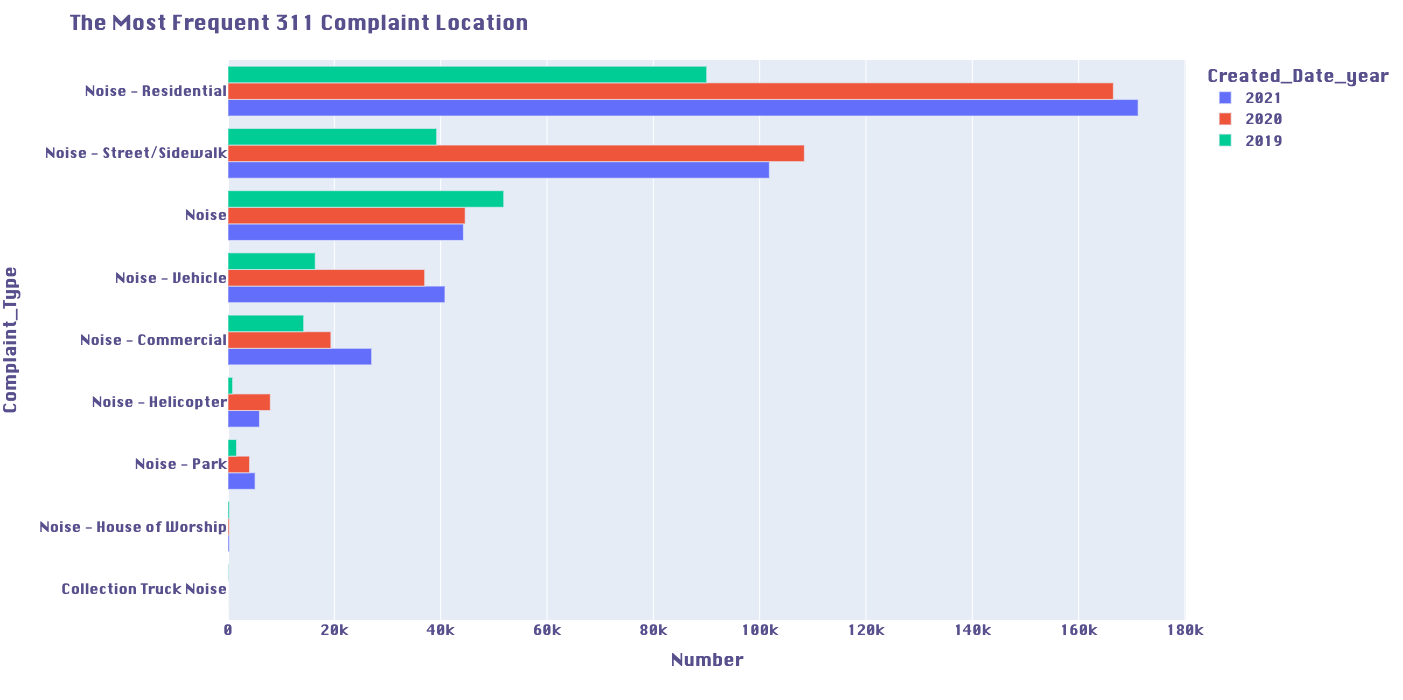

In [20]:
complaint_type_x = list(noise_data["Complaint_Type"].value_counts()[0:10])
complaint_type_y = list(noise_data["Complaint_Type"].value_counts()[0:10].index)

complaint_type_x.reverse()
complaint_type_y.reverse()


complaint_type_count_df = pd.DataFrame({"Total Calls": complaint_type_x, "Complaint Type": complaint_type_y})

complaint_type_fig = px.bar(noise_data_count, x="Number", y="Complaint_Type", 
             orientation='h',barmode='group',
             height=700, color = "Created_Date_year")
             #color_discrete_sequence = px.colors.sequential.thermal)

complaint_type_fig.update_layout(
                  title="The Most Frequent 311 Complaint Location",
                  font=dict(family="silom",
                  size=14, color="#58508d"))

complaint_type_fig.show()

# Complaints Types

In [21]:
noise_data_Descriptor=noise_data.groupby([noise_data['Created_Date_year'],noise_data['Descriptor']]).count()

In [22]:
noise_data_Descriptor = noise_data_Descriptor.reset_index()

In [23]:
noise_data_Descriptor['Descriptor'].unique()

array(['21 Collection Truck Noise', 'Banging/Pounding', 'Car/Truck Horn',
       'Car/Truck Music', 'Engine Idling', 'Loud Music/Party',
       'Loud Talking', 'Loud Television', 'NYPD', 'News Gathering',
       'Noise, Barking Dog (NR5)', 'Noise, Ice Cream Truck (NR4)',
       'Noise, Other Animals (NR6)', 'Noise:  lawn care equipment (NCL)',
       'Noise: Alarms (NR3)', 'Noise: Boat(Engine,Music,Etc) (NR10)',
       'Noise: Construction Before/After Hours (NM1)',
       'Noise: Construction Equipment (NC1)',
       'Noise: Jack Hammering (NC2)',
       'Noise: Loud Music/Daytime (Mark Date And Time) (NN1)',
       'Noise: Loud Music/Nighttime(Mark Date And Time) (NP1)',
       'Noise: Manufacturing Noise (NK1)',
       'Noise: Other Noise Sources (Use Comments) (NZZ)',
       'Noise: Private Carting Noise (NQ1)',
       'Noise: air condition/ventilation equipment (NV1)', 'Other',
       'Noise: Loud Music From Siebel System - For Dep Internal Use Only (NP21)',
       'Noise: Vehicle

In [24]:
#select common complaints type
noise_data_Descriptor_select = noise_data_Descriptor.query('Descriptor=="Loud Music/Party" | Descriptor=="Banging/Pounding"|Descriptor=="Loud Talking"|Descriptor=="Car/Truck Music"|Descriptor=="Noise: Construction Before/After Hours (NM1)"|Descriptor=="Engine Idling"|Descriptor=="Car/Truck Horn"')

In [25]:
noise_data_Descriptor_select

,Created_Date_year,Descriptor,Unnamed: 0,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Complaint_Type,Resolution_Description,Resolution_Action_UpdatedDate,zipcode,Borough,Latitude,Longitude,Location,year-month
1,2019,Banging/Pounding,25777,25777,25777,25777,25777,25777,25777,25777,25777,25777,25777,25777,25777,25777,25777
2,2019,Car/Truck Horn,3544,3544,3544,3544,3544,3544,3544,3544,3544,3544,3544,3544,3544,3544,3544
3,2019,Car/Truck Music,10209,10209,10209,10209,10209,10209,10209,10209,10209,10209,10209,10209,10209,10209,10209
4,2019,Engine Idling,3382,3382,3382,3382,3382,3382,3382,3382,3382,3382,3382,3382,3382,3382,3382
5,2019,Loud Music/Party,103430,103430,103430,103430,103430,103430,103430,103430,103430,103430,103430,103430,103430,103430,103430
6,2019,Loud Talking,13739,13739,13739,13739,13739,13739,13739,13739,13739,13739,13739,13739,13739,13739,13739
16,2019,Noise: Construction Before/After Hours (NM1),24075,24075,24075,24075,24075,24075,24075,24075,24075,24075,24075,24075,24075,24075,24075
27,2020,Banging/Pounding,38808,38808,38808,38808,38808,38808,38808,38808,38808,38808,38808,38808,38808,38808,38808
28,2020,Car/Truck Horn,3368,3368,3368,3368,3368,3368,3368,3368,3368,3368,3368,3368,3368,3368,3368
29,2020,Car/Truck Music,30347,30347,30347,30347,30347,30347,30347,30347,30347,30347,30347,30347,30347,30347,30347


In [26]:
noise_data_Descriptor_select['Created_Date_year'] = noise_data_Descriptor_select['Created_Date_year'].astype(str)

/var/folders/cb/rw9tz7zj639fh06t6jshwfqc0000gn/T/ipykernel_28241/3323431925.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
noise_data_Descriptor_select.rename(columns={'Unnamed: 0':'Number'},inplace=True)

/Users/yufeitang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
noise_data_Descriptor_select = noise_data_Descriptor_select.sort_values(['Created_Date_year','Number'],ascending=True)

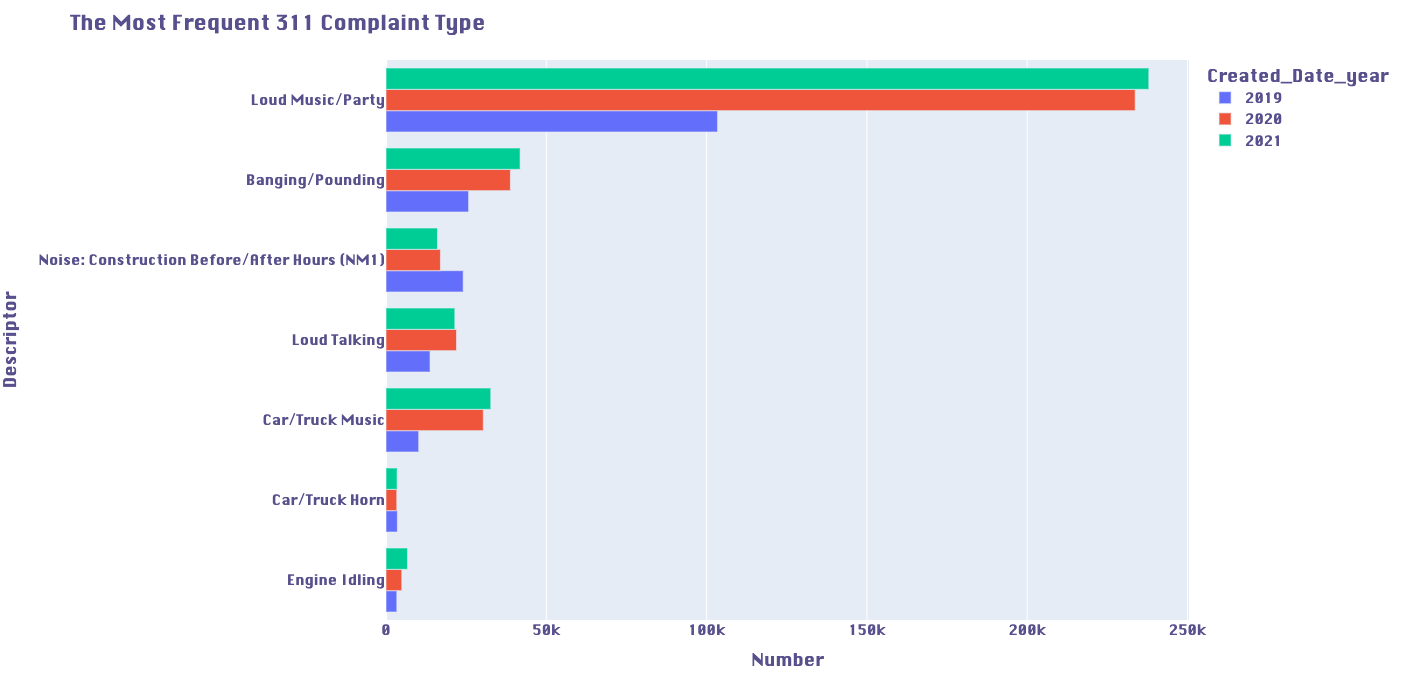

In [29]:
complaint_type_fig = px.bar(noise_data_Descriptor_select, x="Number", y="Descriptor", 
             orientation='h',barmode='group',
             height=700, color = "Created_Date_year")
             #color_discrete_sequence = px.colors.sequential.thermal)

complaint_type_fig.update_layout(
                  title="The Most Frequent 311 Complaint Type",
                  font=dict(family="silom",
                  size=14, color="#58508d"))

complaint_type_fig.show()

# Borough

In [30]:
noise_data_Borough=noise_data.groupby([noise_data['Created_Date_year'],noise_data['Borough']]).count()

In [31]:
noise_data_Borough

Unnamed: 0  Unique_Key  Created_Date  \
Created_Date_year Borough                                               
2019              BRONX               45198       45198         45198   
                  BROOKLYN            61106       61106         61106   
                  MANHATTAN           62901       62901         62901   
                  QUEENS              39037       39037         39037   
                  STATEN ISLAND        6387        6387          6387   
2020              BRONX              106702      106702        106702   
                  BROOKLYN            99045       99045         99045   
                  MANHATTAN          102135      102135        102135   
                  QUEENS              70843       70843         70843   
                  STATEN ISLAND        9421        9421          9421   
2021              BRONX              105156      105156        105156   
                  BROOKLYN           102672      102672        102672   
                  MANHATTAN          113858      113858        113858   
                  QUEENS              66175       66175         66175   
                  STATEN ISLAND        8520        8520          8520   

                                 Closed_Date  Agency  Agency_Name  Descriptor  \
Created_Date_year Borough                                                       
2019              BRONX                45198   45198        45198       45198   
                  BROOKLYN             61106   61106        61106       61106   
                  MANHATTAN            62901   62901        62901       62901   
                  QUEENS               39037   39037        39037       39037   
                  STATEN ISLAND         6387    6387         6387        6387   
2020              BRONX               106702  106702       106702      106702   
                  BROOKLYN             99045   99045        99045       99045   
                  MANHATTAN           102135  102135       102135      102135   
                  QUEENS               70843   70843        70843       70843   
                  STATEN ISLAND         9421    9421         9421        9421   
2021              BRONX               105156  105156       105156      105156   
                  BROOKLYN            102672  102672       102672      102672   
                  MANHATTAN           113858  113858       113858      113858   
                  QUEENS               66175   66175        66175       66175   
                  STATEN ISLAND         8520    8520         8520        8520   

                                 Complaint_Type  Resolution_Description  \
Created_Date_year Borough                                                 
2019              BRONX                   45198                   45198   
                  BROOKLYN                61106                   61106   
                  MANHATTAN               62901                   62901   
                  QUEENS                  39037                   39037   
                  STATEN ISLAND            6387                    6387   
2020              BRONX                  106702                  106702   
                  BROOKLYN                99045                   99045   
                  MANHATTAN              102135                  102135   
                  QUEENS                  70843                   70843   
                  STATEN ISLAND            9421                    9421   
2021              BRONX                  105156                  105156   
                  BROOKLYN               102672                  102672   
                  MANHATTAN              113858                  113858   
                  QUEENS                  66175                   66175   
                  STATEN ISLAND            8520                    8520   

                                 Resolution_Action_UpdatedDate  zipcode  \
Created_Date_year Borough                                     

In [32]:
noise_data_Borough.reset_index(inplace=True)
noise_data_Borough['Created_Date_year']
noise_data_Borough_19 = noise_data_Borough[noise_data_Borough['Created_Date_year']==2019]
#noise_data_Borough_19 = noise_data_Borough_19.drop(index=5)
noise_data_Borough_19 = noise_data_Borough_19.rename(columns={'Unnamed: 0':'Number'})
noise_data_Borough_19

,Created_Date_year,Borough,Number,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Descriptor,Complaint_Type,Resolution_Description,Resolution_Action_UpdatedDate,zipcode,Latitude,Longitude,Location,year-month
0,2019,BRONX,45198,45198,45198,45198,45198,45198,45198,45198,45198,45198,45198,45198,45198,45198,45198
1,2019,BROOKLYN,61106,61106,61106,61106,61106,61106,61106,61106,61106,61106,61106,61106,61106,61106,61106
2,2019,MANHATTAN,62901,62901,62901,62901,62901,62901,62901,62901,62901,62901,62901,62901,62901,62901,62901
3,2019,QUEENS,39037,39037,39037,39037,39037,39037,39037,39037,39037,39037,39037,39037,39037,39037,39037
4,2019,STATEN ISLAND,6387,6387,6387,6387,6387,6387,6387,6387,6387,6387,6387,6387,6387,6387,6387


In [33]:
noise_data_Borough_20 = noise_data_Borough[noise_data_Borough['Created_Date_year']==2020]
#noise_data_Borough_20 = noise_data_Borough_20.drop(index=11)
noise_data_Borough_20 = noise_data_Borough_20.rename(columns={'Unnamed: 0':'Number'})
noise_data_Borough_20

,Created_Date_year,Borough,Number,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Descriptor,Complaint_Type,Resolution_Description,Resolution_Action_UpdatedDate,zipcode,Latitude,Longitude,Location,year-month
5,2020,BRONX,106702,106702,106702,106702,106702,106702,106702,106702,106702,106702,106702,106702,106702,106702,106702
6,2020,BROOKLYN,99045,99045,99045,99045,99045,99045,99045,99045,99045,99045,99045,99045,99045,99045,99045
7,2020,MANHATTAN,102135,102135,102135,102135,102135,102135,102135,102135,102135,102135,102135,102135,102135,102135,102135
8,2020,QUEENS,70843,70843,70843,70843,70843,70843,70843,70843,70843,70843,70843,70843,70843,70843,70843
9,2020,STATEN ISLAND,9421,9421,9421,9421,9421,9421,9421,9421,9421,9421,9421,9421,9421,9421,9421


In [34]:
noise_data_Borough_21 = noise_data_Borough[noise_data_Borough['Created_Date_year']==2021]
#noise_data_Borough_21 = noise_data_Borough_21.drop(index=16)
noise_data_Borough_21 = noise_data_Borough_21.rename(columns={'Unnamed: 0':'Number'})
noise_data_Borough_21

,Created_Date_year,Borough,Number,Unique_Key,Created_Date,Closed_Date,Agency,Agency_Name,Descriptor,Complaint_Type,Resolution_Description,Resolution_Action_UpdatedDate,zipcode,Latitude,Longitude,Location,year-month
10,2021,BRONX,105156,105156,105156,105156,105156,105156,105156,105156,105156,105156,105156,105156,105156,105156,105156
11,2021,BROOKLYN,102672,102672,102672,102672,102672,102672,102672,102672,102672,102672,102672,102672,102672,102672,102672
12,2021,MANHATTAN,113858,113858,113858,113858,113858,113858,113858,113858,113858,113858,113858,113858,113858,113858,113858
13,2021,QUEENS,66175,66175,66175,66175,66175,66175,66175,66175,66175,66175,66175,66175,66175,66175,66175
14,2021,STATEN ISLAND,8520,8520,8520,8520,8520,8520,8520,8520,8520,8520,8520,8520,8520,8520,8520


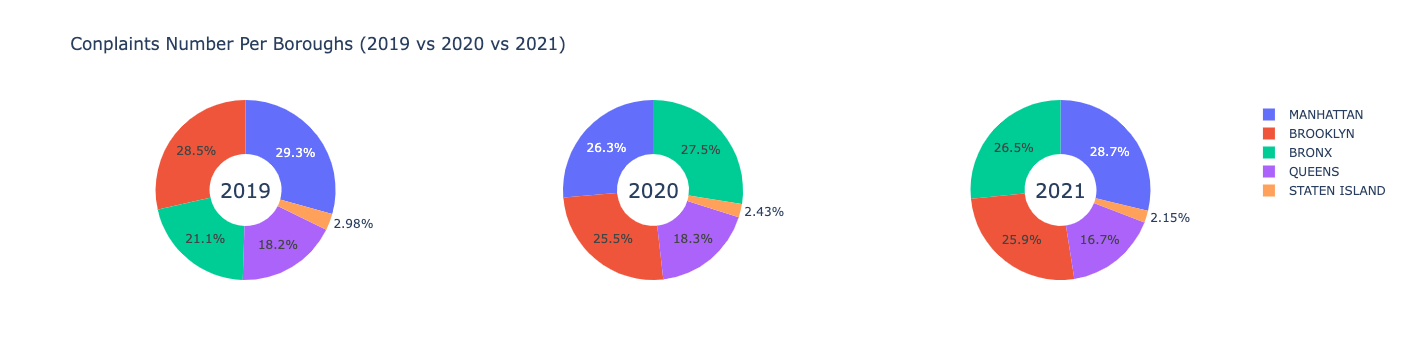

In [35]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
labels = noise_data_Borough_19['Borough']
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=noise_data_Borough_19['Number'], name="2019"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=noise_data_Borough_20['Number'], name="2020"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=noise_data_Borough_21['Number'], name="2021"),
              1, 3)
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="Conplaints Number Per Boroughs (2019 vs 2020 vs 2021)",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='2019', x=0.12, y=0.5, font_size=20, showarrow=False),
                 dict(text='2020', x=0.5, y=0.5, font_size=20, showarrow=False),
                 dict(text='2021', x=0.88, y=0.5, font_size=20, showarrow=False),
                 ])
fig.show() 

# Wordcloud

In [36]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

def clean_words(text):
    
    """Takes in a string or iterable of strings, and returns a cleaned list 
       of words in the text that was passed in."""
    
    #join all strings in text and separate them by white space
    joined_text = " ".join(text) 
    
    #remove all characters that are not letters
    joined_text = re.sub('[^A-Za-z ]+', ' ', joined_text)
    
    #convert all words in list to their base form, or 'lemma'
    words = [WordNetLemmatizer().lemmatize(word) for word in joined_text]
    
    #create a list of individual strings for each word in the text 
    words = word_tokenize(joined_text)
    
    
    clean_words_list = []
    
    for word in words:
        
        #exclude words that don't contribute to the meaning of the text
        stopwords_list = stopwords.words('english')
        for w in ['http', 'com', 'amp', 'www']:
            stopwords_list.append(w)
        
        if len(word) > 2 and word not in stopwords_list:
            
            #populate clean words list with remaining words
            clean_words_list.append(word.lower())
    
    return clean_words_list

[nltk_data] Downloading package punkt to /Users/yufeitang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yufeitang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yufeitang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
noise_data_sample = noise_data.sample(n=100000,axis=0)

In [38]:
clean_descriptor = clean_words(noise_data_sample.Descriptor)

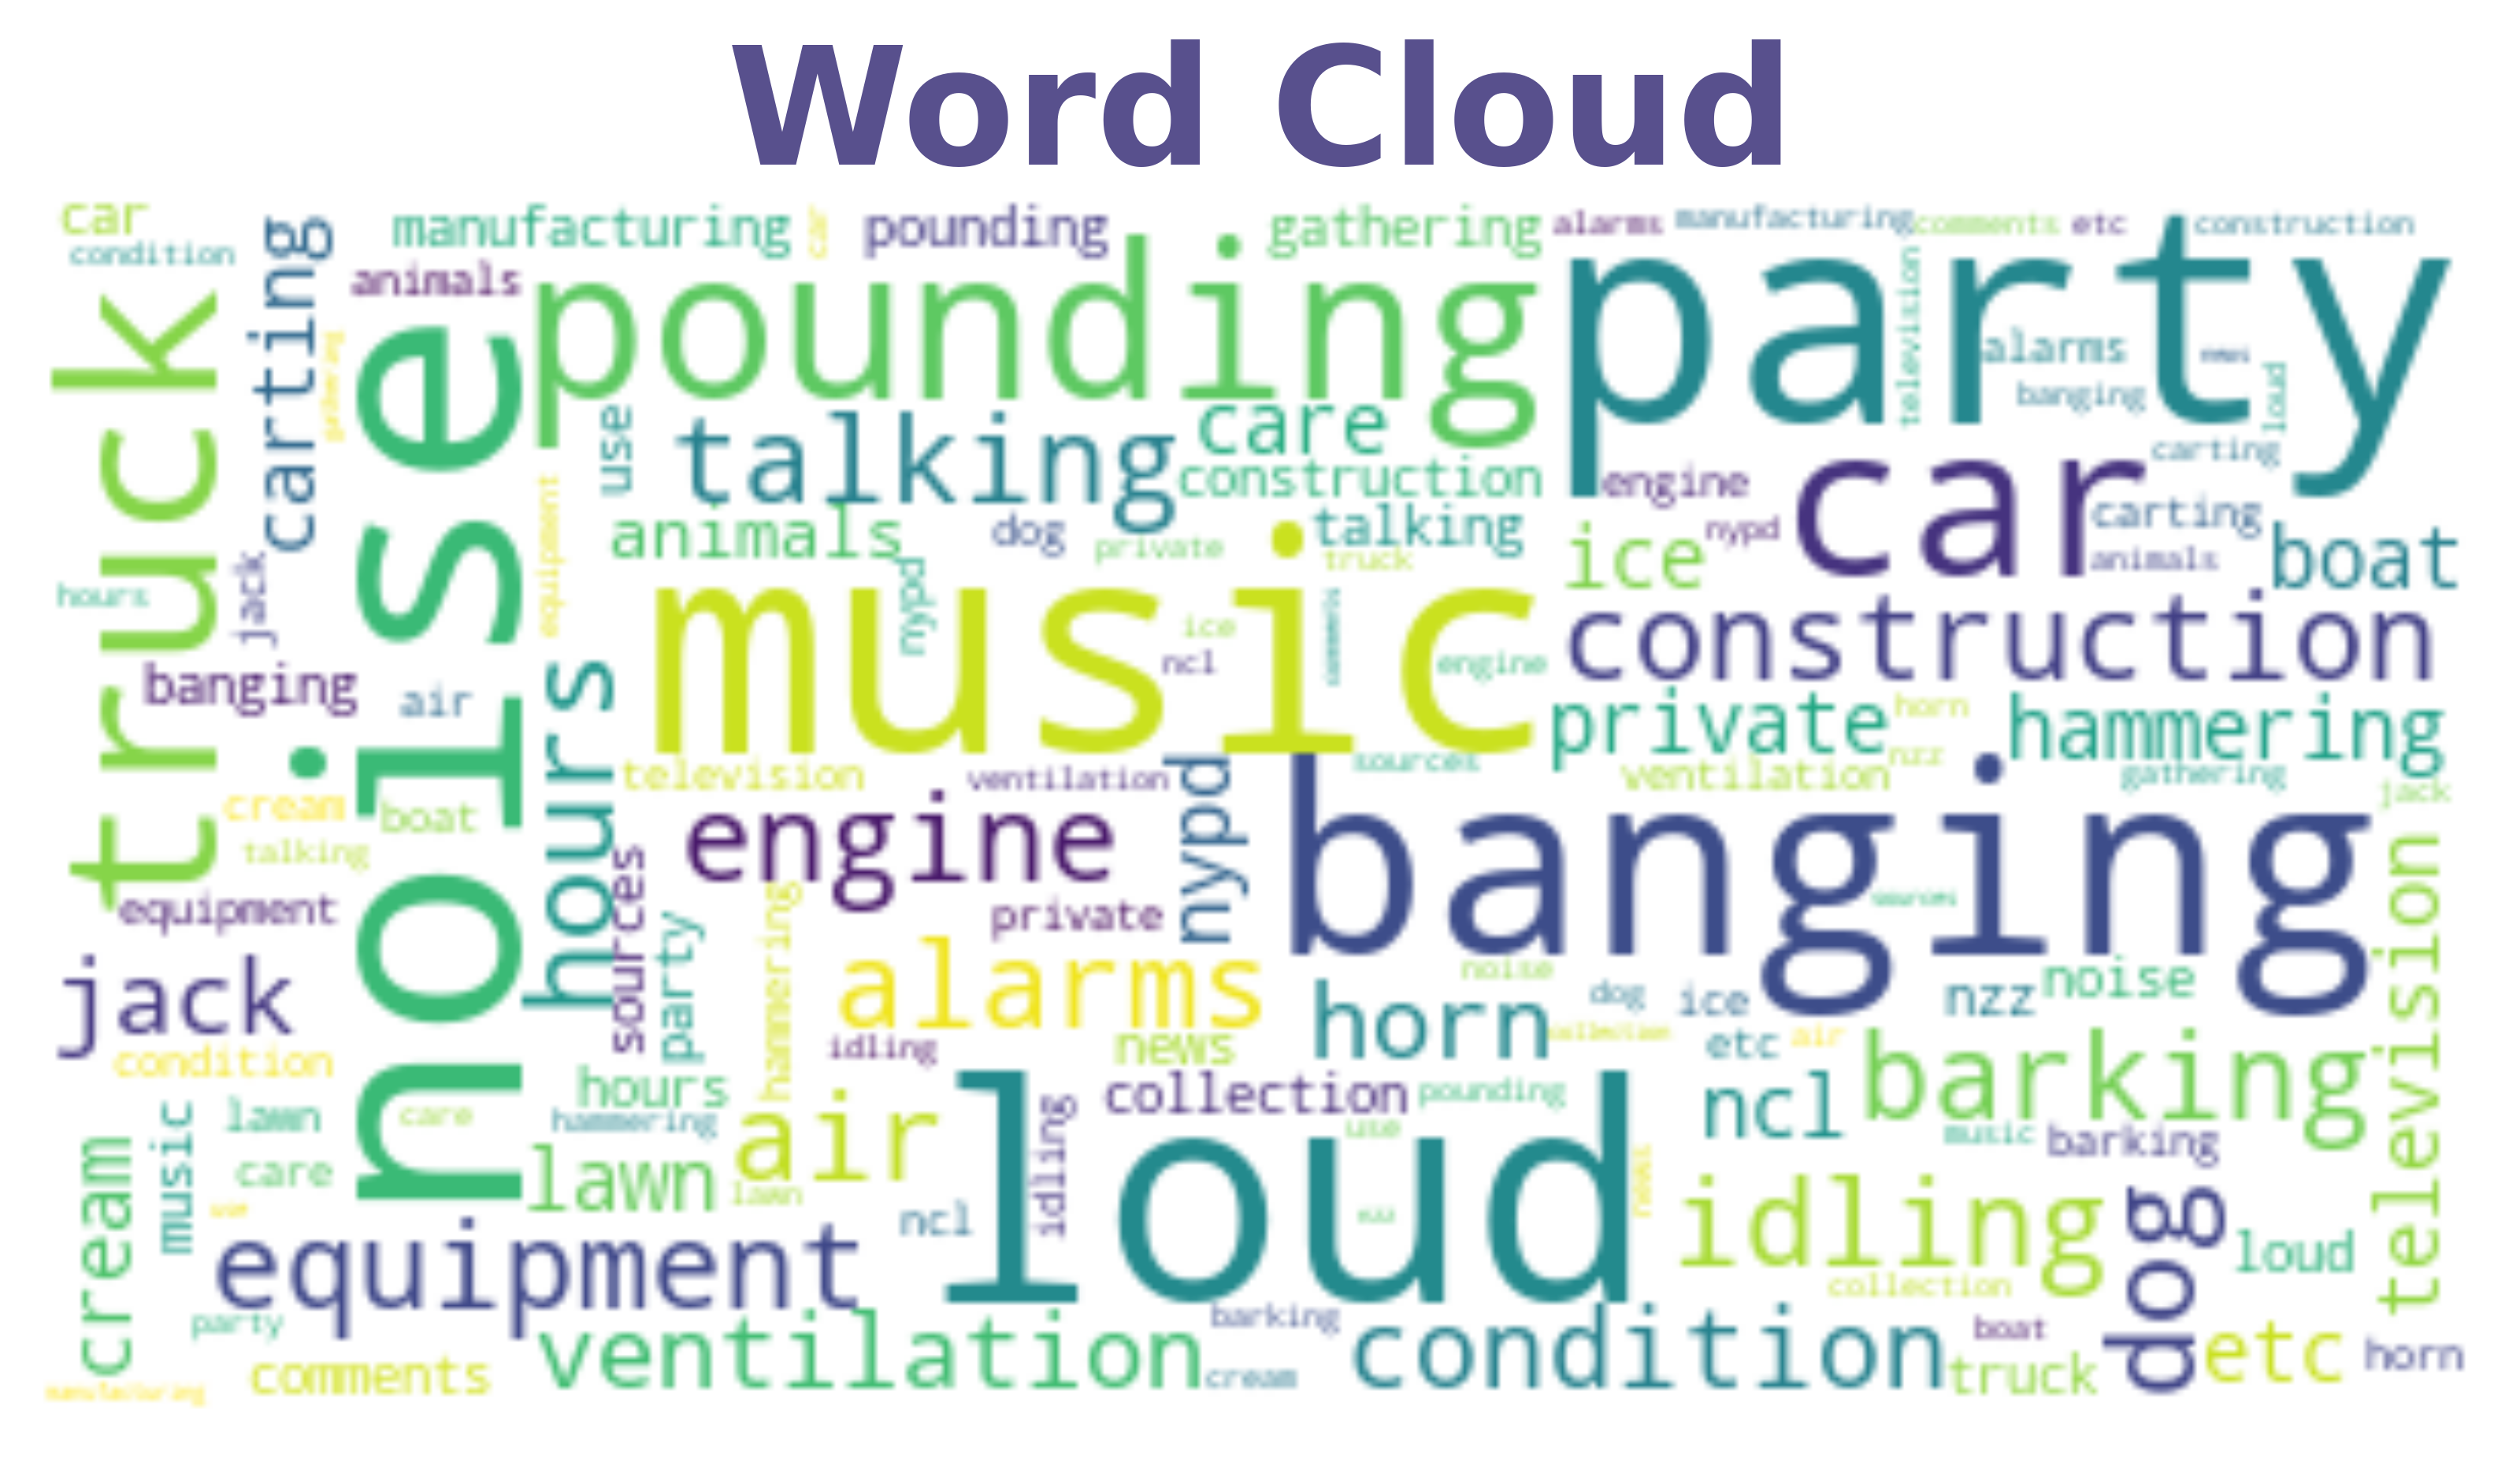

In [39]:
#generate the wordcloud for descriptor
wc = WordCloud(background_color="white", max_words=100,
               max_font_size =50, collocations=False,
               contour_width=2, contour_color='#51788c',repeat=True)

clean_string = '.'.join(clean_descriptor)
wc.generate(clean_string)

f = plt.figure(figsize=(8,12),dpi=500)
plt.axis("off")
plt.imshow(wc, interpolation='bilinear')

font_dict = {'fontsize': 30, 'color': '#58508d', 'weight': 'bold'}

plt.title('Word Cloud', fontdict=font_dict)
plt.axis("off")
plt.show()